## Autoencoders

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))

In [3]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [4]:
from fastcore.test import test_close
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

### Data

In [5]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name, ignore_verifications=True)

/home/agastya/mambaforge/lib/python3.10/site-packages/datasets/load.py:2097: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


In [6]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [7]:
bs = 256
tds = dsd.with_transform(transformi)

<Axes: >

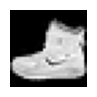

In [8]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1))

In [9]:
cf = collate_dict(ds)

In [10]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): 
    return {k: DataLoader(v, bs, **kwargs) for k, v in dsd.items()}

In [11]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [12]:
dt = dls['train']
dv = dls['test']

xb, yb = next(iter(dt))

In [13]:
xb.shape

torch.Size([256, 1, 28, 28])

In [14]:
labels = ds.features[y].names

In [15]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [16]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

In [17]:
titles

('Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal',
 'T - shirt / top',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Ankle boot')

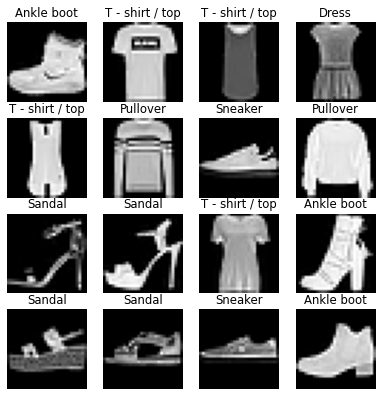

In [18]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

In [19]:
from torch import optim

bs = 256
lr = 0.4

In [20]:
cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [21]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.8871499663352966 0.6953
1 0.6235409275054932 0.7778
2 0.48479274845123294 0.8313
3 0.4645039219379425 0.8318
4 0.4356199478149414 0.8451


In [22]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

## Autoencoder 

In [23]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [24]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

In [25]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

In [26]:
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
    # conv(4,8),        #4x4
    # deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

In [27]:
eval(ae, F.mse_loss, dv)

0 0.182


In [28]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(10, ae, F.mse_loss, opt, dt, dv)

0 0.154
1 0.139
2 0.130
3 0.126
4 0.125
5 0.125
6 0.125
7 0.125
8 0.125
9 0.125


In [29]:
p = ae(xb)

In [30]:
p[0,0,:10,:10]

tensor([[0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29],
        [0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29],
        [0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29],
        [0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29],
        [0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29],
        [0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29],
        [0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29],
        [0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29],
        [0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29],
        [0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29]], device='cuda:0', grad_fn=<SliceBackward0>)

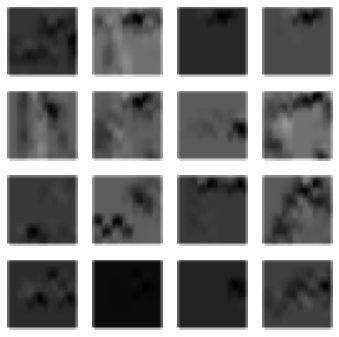

In [31]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

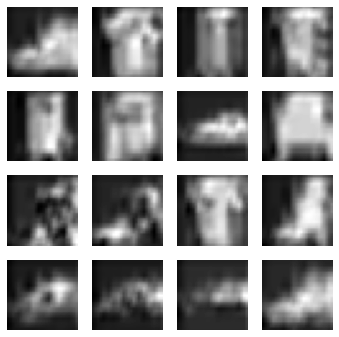

In [51]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

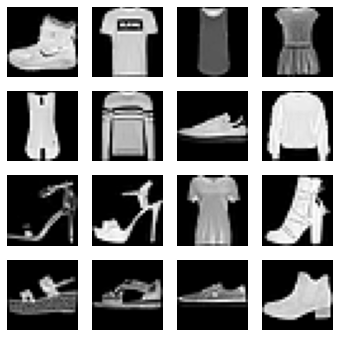

In [46]:
show_images(xb[:16].data.cpu(), imsize=1.5)